In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from aux_files.empirical_study_tspl import find_optimal_parameters_tspl
import matplotlib.pyplot as plt
from aux_files.utils import *

In [3]:
dfs = []
for year in range(2008, 2024):
    df = pd.read_csv(f'data_ex4/P_SSVI_{year}.csv',sep=';')
    df2 = pd.read_csv(f'data_fwd/option_fwd_price_{year}.csv',sep=';')
    unique_dates = df2['date'].unique()
    df['date'] = unique_dates
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    dfs.append(df)

In [4]:
unified_df = pd.concat(dfs)

In [5]:
unified_df.to_csv(f'P_SSVI_all.csv', sep=';')

In [303]:
ssvi = pd.read_csv('P_SSVI_all.csv', sep=';')
#ssvi['p'] = np.log(ssvi['p'])
ssvi['date'] = pd.to_datetime(ssvi['date'])
ssvi = ssvi.set_index('date')
ssvi.drop(columns=['Unnamed: 0.1', "Unnamed: 0"], inplace=True)
#ssvi.index.name = None

In [ ]:
load_from = pd.to_datetime('2008-01-02') 
train_start_date = pd.to_datetime('2012-03-08')
test_start_date = pd.to_datetime('2022-03-01')
test_end_date = pd.to_datetime('2023-08-31')

In [221]:
spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
spx_data.index = pd.to_datetime(spx_data.index.date)
spx = spx_data['Close']

In [349]:
merged = ssvi.merge(spx.rename('underlying_price'), 
                       left_on='date', 
                       right_index=True)

In [223]:
percentile_99 = merged['a'].quantile(0.95)
merged['a'] = merged['a'].where(merged['a'] <= percentile_99, float('nan'))
merged['a'] = merged['a'].fillna(method='ffill')

In [ ]:
percentile_99 = merged['p'].quantile(0.95)
percentile_01 = merged['p'].quantile(0.05)
merged['p'] = merged['p'][(merged['p'] <= percentile_99) & (merged['p'] >= percentile_01)]

In [361]:
load_from = pd.to_datetime('2008-01-02') 
train_start_date = pd.to_datetime('2012-03-08')
test_start_date = pd.to_datetime('2022-03-01')
test_end_date = pd.to_datetime('2023-08-31')

In [352]:
merged['logp'] = np.log(merged['p']) + 0.2

In [ ]:
train_r2, test_r2 = [], []
for param in ['logp','p']:
    vol = pd.Series(
        data=merged[param].values,
        index=merged.index,
        name=None 
    )
    spx = pd.Series(
        data=merged['underlying_price'].values,
        index=merged.index,
        name=None 
    )
    p = 1
    max_delta = 2000
    lambda_reg = 10**-2
    setting = [(1, 1), (2, 1/2)] 
    sol = find_optimal_parameters_tspl(index=spx, vol=vol, setting=setting, train_start_date=train_start_date, test_start_date=test_start_date,
                  test_end_date=test_end_date, max_delta=max_delta, fixed_initial=False, use_jacob=True,p=p,lambda_reg=lambda_reg)

    print(param, sol['train_r2'], sol['test_r2'])
    train_r2.append(sol['train_r2'])
    test_r2.append(sol['test_r2'])

p 0.3416312617911711 0.07025599245254244


In [ ]:
load_from = pd.to_datetime('2008-01-02') 
train_start_date = pd.to_datetime('2012-03-08')
test_start_date = pd.to_datetime('2022-08-01')
test_end_date = pd.to_datetime('2023-08-31')

In [ ]:
train_r2, test_r2 = [], []
for param in ['a']:
    vol = pd.Series(
        data=merged[param].values,
        index=merged.index,
        name=None 
    )
    spx = pd.Series(
        data=merged['underlying_price'].values,
        index=merged.index,
        name=None 
    )
    #print(vol.head())
    p = 1
    setting = [(1, 1), (2, 1/2)] 
    sol = find_optimal_parameters_tspl(vol=vol, index=spx, p=p, tspl=True, setting=setting, train_start_date=train_start_date,
                                        test_start_date=test_start_date, test_end_date=test_end_date, 
                                        max_delta=1000, lambda_reg=0)

    print(param, sol['train_r2'], sol['test_r2'])
    train_r2.append(sol['train_r2'])
    test_r2.append(sol['test_r2'])

In [267]:
load_from = pd.to_datetime('2008-01-02') 
train_start_date = pd.to_datetime('2012-03-08')
test_start_date = pd.to_datetime('2022-03-01')
test_end_date = pd.to_datetime('2023-01-01')
train_r2, test_r2 #2000, 10**-2

([0.158097514076727], [0.5431371790918884])

In [364]:
# plot timeseries of predictions vs true
pred_on_test = sol['test_pred'] 
pred_on_train = sol['train_pred']
target_on_test = data_between_dates(vol, start_date=test_start_date, end_date=test_end_date) 
target_on_train = data_between_dates(vol, start_date=train_start_date, end_date=test_start_date)
index_on_test = data_between_dates(spx, start_date=test_start_date, end_date=test_end_date)
index_on_train = data_between_dates(spx, start_date=train_start_date, end_date=test_start_date)

In [357]:
def plot_volatility_predictions(y_pred, y_true, index_series=None, 
                                color_pred='blue', color_true='orange', color_index='g',
                                figsize=(12, 6), label_index='$S_t$', 
                                ylabel=r'$log p + 0.2$', legend_loc='lower left',
                                linewidth_pred=1, linewidth_true=1, alpha_pred=0.7):
    fig, ax = plt.subplots(figsize=figsize)

    # Plot true and predicted volatility
    y_true.plot(ax=ax, color=color_true, label='True', linewidth=linewidth_true)
    y_pred.plot(ax=ax, color=color_pred, label='Predicted', linestyle='-', alpha=alpha_pred, linewidth=linewidth_pred)

    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    ax.legend(loc=legend_loc, framealpha=0.7)

    # Plot index on secondary y-axis if provided
    if index_series is not None:
        ax2 = ax.twinx()
        ax2.set_ylabel(label_index)
        ax2.tick_params(axis='y')
        index_series.plot(ax=ax2, color=color_index, linestyle='-.', linewidth=1, alpha=0.5)
        ax2.grid(False)
        ax2.set_title(r'True vs Predicted Values for $log p +0.2$', fontsize=16)
    
    return fig

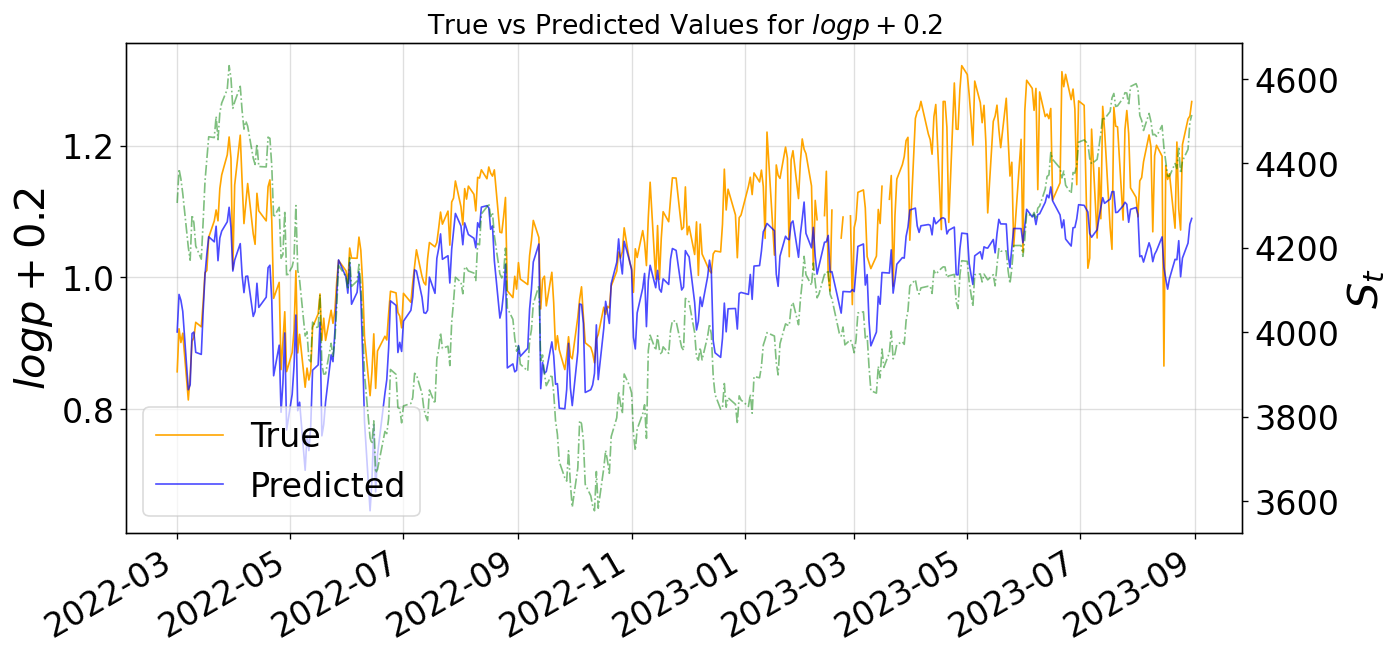

In [ ]:
fig = plot_volatility_predictions(y_true=target_on_test, y_pred=pred_on_test, index_series=index_on_test)